In [1]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import matplotlib.pyplot as plt
import glob
import os
import geopandas as gpd

from shapely.geometry import Polygon
from shapely.geometry import mapping

from atlite.gis import ExclusionContainer, shape_availability

In [2]:
tiff_paths = [
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/15degrees.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/2000m.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/airport_airports_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/glacier_glacier_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_buffered175_175.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/military_military_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/powerlines_powerlines_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/radar_radar_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/rail_narrow_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/rail_rail_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_motorway_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_trunk_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_motorway_link_buffered.tif',    
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_primary_primary_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/shipping_lanes_high_pass_shipping_lanes_high_pass_buffered.tif'
]

In [3]:
src_files_to_mosaic = []

for fp in tiff_paths:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)
    
# Merge the raster files
mosaic, out_transform = merge(src_files_to_mosaic)

# Close the file connections
for src in src_files_to_mosaic:
    src.close()

# Define the output file path
output_file = '/home/oskar/shared_input/geodata/onshore/wimby/processed/technical_exclusions.tif'

# Copy the metadata from one of the original files
out_meta = src.meta.copy()

# Update the metadata to match the merged data
out_meta.update({
    'driver': 'GTiff',
    'height': mosaic.shape[1],
    'width': mosaic.shape[2],
    'transform': out_transform,
    'count': mosaic.shape[0],
    'compress': 'lzw'  # Adding LZW compression
})

# Write the merged file
with rasterio.open(output_file, "w", **out_meta) as dest:
    dest.write(mosaic)


In [4]:
def plot_eligible_area(ax, tiff_path, europe, title):
    excluder_wind_onshore = ExclusionContainer()

    # Ensuring the correct CRS for full_europe
    full_europe = (
        europe
        .assign(col='a')
        .dissolve(by='col')
        .geometry
    )

    # Open the TIFF file and ensure CRS matches
    with rasterio.open(tiff_path) as src:
        if full_europe.crs != src.crs:
            full_europe = full_europe.to_crs(src.crs)

    # Bufffer geometry ensuring CRS consistency
    full_europe = full_europe.to_crs(excluder_wind_onshore.crs)

    # Example mask and transformation logic
    excluder_wind_onshore.add_raster(tiff_path)
    masked, transform = shape_availability(full_europe, excluder_wind_onshore)
    eligible_share = (masked.sum() * excluder_wind_onshore.res**2 / full_europe.geometry.item().area)
    
    # Plot the eligible area in a subplot
    show(masked, transform=transform, cmap='Greens', ax=ax)
    full_europe.plot(ax=ax, edgecolor='k', color='None')
    europe.to_crs(excluder_wind_onshore.crs).boundary.plot(ax=ax, edgecolor='grey', linewidth=0.2)
    ax.set_title(f'{title} Eligible area (green) {eligible_share * 100:2.2f}%')

In [5]:
aggregated_regions = [
    "AT", "BE", "BG", "CH", "CZ", "DE",
    "DK", "EE", "ES", "FI", "FR", "UK",
    "GR", "HR", "HU", "IE", "IT", "LT",
    "LU", "LV", "NL", "NO", "PL", "PT", 
    "RO", "SE", "SI", "SK",
]

In [6]:
europe = (
    gpd
    .read_file('/home/oskar/shared_input/geodata/onshore/shapes/NUTS_RG_10M_2021_4326.geojson')
    .query("NUTS_ID == @aggregated_regions")
    .set_index(["NUTS_ID"])
    .loc[:,['geometry']]
)

In [7]:
europe

,geometry
NUTS_ID,
AT,"POLYGON ((15.12428 48.99643, 15.19002 48.95116..."
BE,"POLYGON ((4.82863 51.48026, 4.84105 51.42781, ..."
DK,"MULTIPOLYGON (((14.8254 55.2541, 14.94371 55.2..."
DE,"MULTIPOLYGON (((9.22352 54.85127, 9.27178 54.8..."
NL,"MULTIPOLYGON (((6.8749 53.40801, 6.91836 53.34..."
PL,"MULTIPOLYGON (((18.75214 54.37506, 18.95003 54..."
PT,"MULTIPOLYGON (((-8.2074 41.91949, -8.16508 41...."
UK,"MULTIPOLYGON (((-0.19819 51.46752, -0.21534 51..."
ES,"MULTIPOLYGON (((4.28746 39.82237, 4.24593 39.8..."


In [8]:
offshore_to_ISO3166 = {
    "Albania"        : "AL",
    "Belgium"        : "BE",
    "Bulgaria"       : "BG",
    "Croatia"        : "HR",
    "Cyprus"         : "CY",
    "Denmark"        : "DK",
    "Estonia"        : "EE",
    "Finland"        : "FI",
    "France"         : "FR",
    "Germany"        : "DE",
    "Greece"         : "GR",
    "Ireland"        : "IE",
    "Italy"          : "IT",
    "Latvia"         : "LV",
    "Lithuania"      : "LT",
    "Malta"          : "MT",
    "Netherlands"    : "NL",
    "Poland"         : "PL",
    "Portugal"       : "PT",
    "Romania"        : "RO",
    "Spain"          : "ES",
    "Slovenia"       : "SI",
    "Slovakia"       : "SK",
    "Sweden"         : "SE",
    "United Kingdom" : "UK"
}

In [9]:
europe_off = (
    gpd
    .read_file('/home/oskar/shared_input/geodata/offshore/BOTTOM_MOUNTED_EUROPE_NUTS0_NORWAY_NUTS3.geojson')
    .loc[:,['index','geometry']]
    .replace(offshore_to_ISO3166)
    .rename(columns={'index' : 'NUTS_ID'})
    .set_index('NUTS_ID')
    
)
europe_off

,geometry
NUTS_ID,
AL,"MULTIPOLYGON (((19.78292 39.93611, 19.78218 39..."
BE,"POLYGON ((3.27669 51.45813, 3.26904 51.45617, ..."
BG,"MULTIPOLYGON (((28.19857 42.10508, 28.2 42.1, ..."
HR,"MULTIPOLYGON (((16.0375 42.55833, 16.025 42.55..."
CY,"POLYGON ((34.86618 35.87644, 34.85 35.85833, 3..."
DK,"MULTIPOLYGON (((15.38306 54.73795, 15.3875 54...."
EE,"MULTIPOLYGON (((20.5767 58.0608, 20.575 58.058..."
FI,"MULTIPOLYGON (((20.85274 59.33008, 20.85417 59..."
FR,"MULTIPOLYGON (((8.76913 41.2858, 8.77083 41.28..."


In [10]:
# The square outer boundaries of Europe to consider, because we have downloaded ERA5 for this extent:
rectx1 = -12
rectx2 = 44
recty1 = 33
recty2 = 72

In [11]:
polygon = Polygon(
    [
        (rectx1, recty1),
        (rectx1, recty2),
        (rectx2, recty2),
        (rectx2, recty1),
        (rectx1, recty1),
    ]
)
europe = gpd.clip(europe, polygon)
europe_off = gpd.clip(europe_off, polygon)

/home/oskar/miniconda3/envs/analysis/lib/python3.12/site-packages/atlite/gis.py:489: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


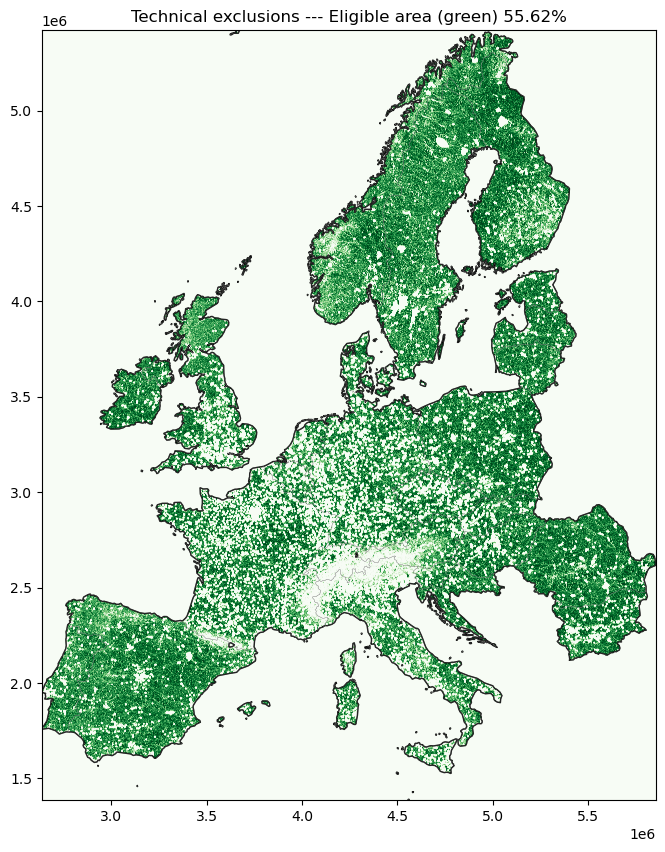

In [12]:
fig, ax = plt.subplots(1,1,figsize=(16,10))

plot_eligible_area(ax, '/home/oskar/shared_input/geodata/onshore/wimby/processed/technical_exclusions.tif', europe, 'Technical exclusions ---')

/home/oskar/miniconda3/envs/analysis/lib/python3.12/site-packages/atlite/gis.py:489: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


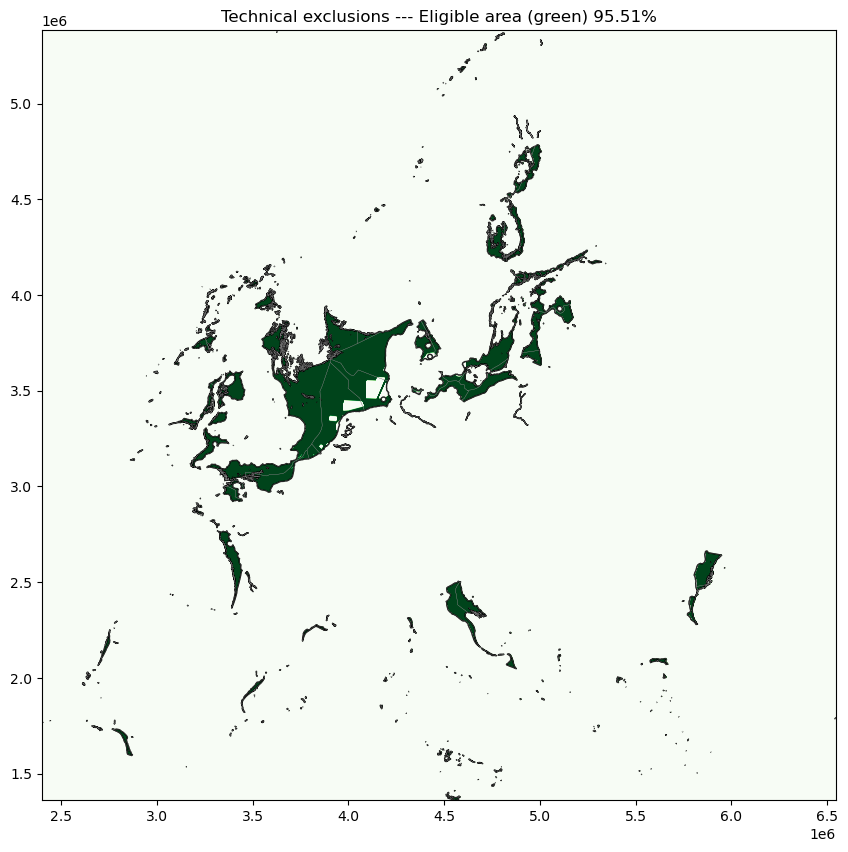

In [13]:
fig, ax = plt.subplots(1,1,figsize=(16,10))

plot_eligible_area(ax, '/home/oskar/shared_input/geodata/onshore/wimby/processed/technical_exclusions.tif', europe_off, 'Technical exclusions ---')

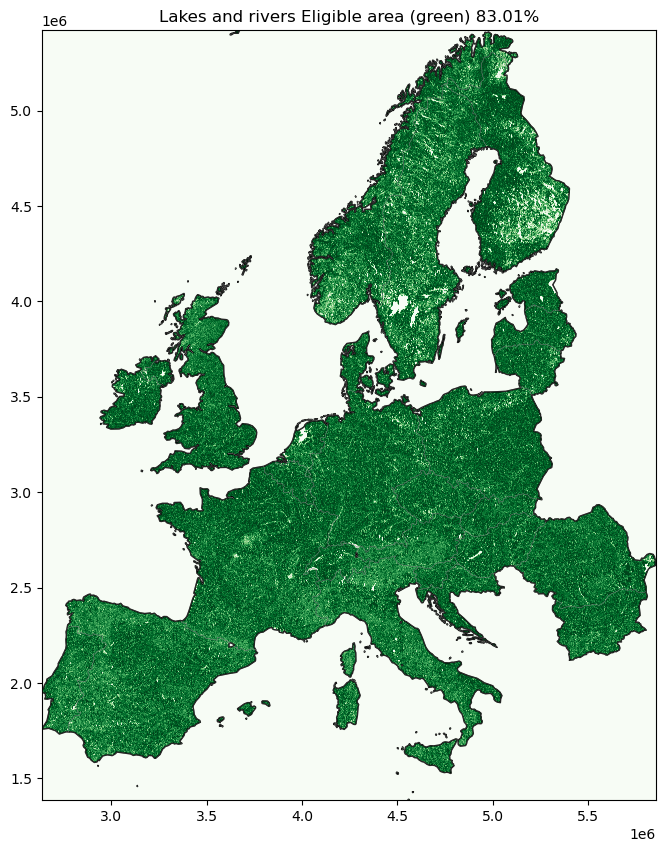

In [13]:
#fig, ax = plt.subplots(1,1,figsize=(16,10))
#
#plot_eligible_area(ax, '/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_buffered.tif', europe, 'Lakes and rivers')